In [83]:
from matplotlib import pyplot as plt
import os
import numpy as np
import pandas as pd
from tqdm import tqdm, tqdm_notebook, tnrange
import glob

from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from PIL import Image, ImageDraw, ImageFile

from skimage.external import tifffile


import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam



In [2]:
!pwd

/home/greg/Documents/metis/satellite-image-classification


In [3]:
# constants
base = 'satellite-image-classification'
data_dir = 'data/spacenet/'
AOI = 'AOI_2_Vegas_Train/'


image_prefix = 'RGB-PanSharpen_' # RGB-PanSharpen_AOI_2_Vegas_img1.tif
geojson_prefix = 'buildings_' # buildings_AOI_2_Vegas_img1.geojson

image_dir = os.path.join( data_dir, AOI, 'RGB-PanSharpen')
geojson_dir = os.path.join(data_dir, AOI, 'geojson', 'buildings')
output_dir = os.path.join(data_dir, AOI, 'RGB-PanSharpen_masks')


image_dimension = 650
image_channels = 3

dtype_float = np.float32

train_percentage = 1


In [4]:
summary_csv = os.path.join(data_dir, AOI, 'summaryData', 'AOI_2_Vegas_Train_Building_Solutions.csv')
summary_csv


'data/spacenet/AOI_2_Vegas_Train/summaryData/AOI_2_Vegas_Train_Building_Solutions.csv'

In [4]:
summary_csv = os.path.join(data_dir, AOI, 'summaryData', 'AOI_2_Vegas_Train_Building_Solutions.csv')
# summary_csv = 'data/spacenet/AOI_2_Vegas_Train/summaryData/AOI_2_Vegas_Train_Building_Solutions.csv'
df = pd.read_csv(summary_csv)

In [5]:
df.head(2)

,ImageId,BuildingId,PolygonWKT_Pix,PolygonWKT_Geo
0,AOI_2_Vegas_img1209,1,"POLYGON ((68.71 623.1 0,35.71 618.15 0,33.59 6...","POLYGON ((-115.27398708 36.20208033800003 0,-1..."
1,AOI_2_Vegas_img1209,2,"POLYGON ((221.33 645.02 0,185.7 640.33 0,184.4...",POLYGON ((-115.273575016999985 36.202021143000...


In [6]:
image_ids = sorted(df['ImageId'].unique())

['AOI_2_Vegas_img1', 'AOI_2_Vegas_img10', 'AOI_2_Vegas_img1000']

In [7]:
for index, image_id in tqdm_notebook(enumerate(image_ids), total=len(image_ids)) :
    if index == 3:
        break
    print(image_id)

AOI_2_Vegas_img1
AOI_2_Vegas_img10
AOI_2_Vegas_img1000


In [8]:
image_file = '/home/greg/Documents/metis/satellite-image-classification/RGB-PanSharpen_AOI_2_Vegas_img1.tif'

img = tifffile.imread(image_file)
if os.path.exists(image_file + 'a'):
    print('yes')

In [9]:
img.max()

1772

/home/greg/anaconda3/envs/metis/lib/python3.7/site-packages/skimage/external/tifffile/tifffile.py:6164: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  valfmt='%%.0f [%i]' % data.shape[axis]) for axis in range(dims)]


(<Figure size 988.8x604.8 with 3 Axes>,
 <matplotlib.image.AxesImage at 0x7f8fc07cfb10>)

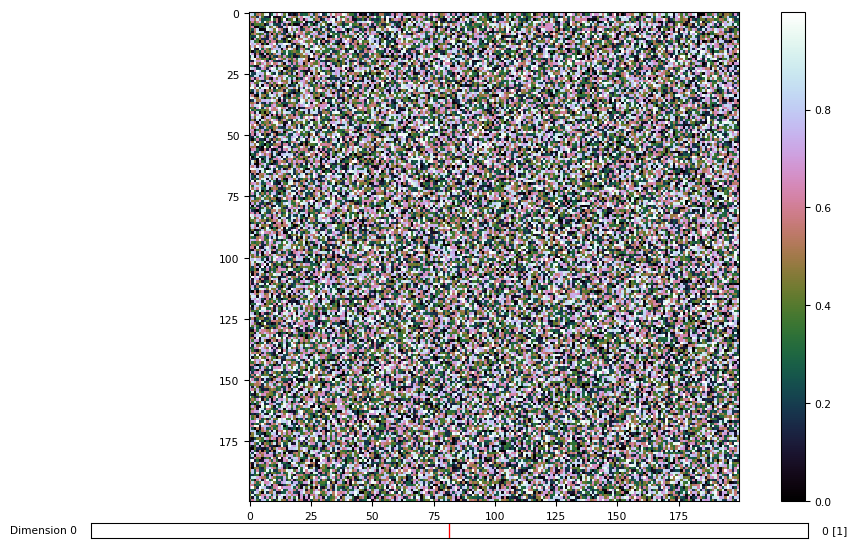

In [10]:
tifffile.imshow(np.random.rand(200, 200))

In [30]:
total_ids = image_ids
train_index = int((len(total_ids) * train_percentage) // 1)
ids = image_ids[:train_index]

X = np.zeros((len(ids), image_dimension, image_dimension, image_channels), dtype=dtype_float)
y = np.zeros((len(ids), image_dimension, image_dimension, image_channels), dtype=dtype_float)

print('Getting and resizing images ... ')

x_min = 1000
x_max = 0
y_min = 1000
y_max = 0

for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
    # Load images
    image_path = os.path.join(image_dir, f'{image_prefix}{id_}.tif')
    mask_path = os.path.join(output_dir, f'{id_}_mask.tif')
    
    if not (os.path.exists(image_path) and os.path.exists(mask_path)):
        continue
    
    img = tifffile.imread(image_path)
    
    x_img = img
    x_mask = x_img
    x_mask_min = x_mask.min()
    x_mask_max = x_mask.max()
    if x_mask_max > x_max:
        x_max = x_mask_max
    
    if x_mask_min < x_min:
        x_min = x_mask_min
                  
#     x_img = img_to_array(img)
#     x_img = resize(x_img, (image_dimension, image_dimension, image_channels),
#                    mode='constant', preserve_range=True)

    # Load masks
    mask = tifffile.imread(mask_path)
    y_mask = mask
    
    y_mask_min = y_mask.min()
    y_mask_max = y_mask.max()
    if y_mask_max > y_max:
        y_max = y_mask_max
    
    if y_mask_min < y_min:
        y_min = y_mask_min
    
    
#     y_mask = img_to_array(mask)
#     y_mask = resize(mask, (image_dimension, image_dimension, image_channels),
#                   mode='constant', preserve_range=True)

    # Save images
#     X[n, ...] = x_img.squeeze()
#     y[n, ..., 0] = y_mask


Getting and resizing images ... 


In [31]:
print(x_min, x_max, y_min, y_max)

0 2047 0 255


In [69]:
Xt = np.zeros((2, 5, 5, 2))
xtimg = np.ones((5, 5, 2))

In [79]:
Xt[0, ...,] = xtimg

IndexError: index 2 is out of bounds for axis 3 with size 2

In [73]:
Xt

array([[[[1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.]],

        [[1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.]],

        [[1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.]],

        [[1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.]],

        [[1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.]]],


       [[[0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.]]]])

In [23]:

arr = np.random.randint(0, 1000, size=(8, 8, 8))

In [24]:
np.amax(arr.flat)

999

In [26]:
arr.flatten().sort()

In [28]:
np.sort(arr.flatten())

array([  1,   4,   5,   6,   6,   6,   6,   8,   9,   9,  11,  12,  12,
        14,  20,  20,  20,  21,  24,  24,  26,  27,  27,  27,  27,  29,
        33,  38,  41,  42,  46,  52,  53,  53,  54,  54,  55,  55,  58,
        59,  63,  64,  65,  65,  67,  68,  69,  72,  73,  73,  76,  76,
        78,  79,  80,  82,  85,  86,  88,  95,  96,  99, 103, 107, 108,
       112, 113, 113, 115, 117, 118, 120, 120, 120, 123, 123, 124, 124,
       126, 127, 127, 128, 130, 132, 136, 137, 139, 143, 145, 145, 147,
       148, 151, 152, 154, 155, 157, 161, 163, 165, 165, 165, 168, 169,
       170, 171, 172, 176, 178, 180, 180, 183, 184, 184, 190, 190, 190,
       191, 192, 192, 196, 197, 205, 207, 210, 214, 215, 221, 221, 222,
       225, 228, 228, 230, 233, 233, 234, 234, 234, 235, 237, 237, 239,
       244, 247, 249, 253, 255, 263, 267, 269, 270, 274, 274, 275, 279,
       280, 284, 290, 294, 295, 297, 297, 298, 299, 302, 303, 303, 305,
       306, 311, 312, 313, 313, 315, 316, 324, 329, 333, 336, 33

In [5]:
arr = np.array(['00'] * 4 + ['01']*4 + ['02']*4 + ['03']*4 + ['10'] * 4 + ['11'] * 4 + ['12']*4 + ['13'] * 4)

In [6]:
arr = np.array([0] * 4 + [50]*4 + [100]*4 + [150]*4 + [200] * 4 + [250] * 4 + [0]*4 + [100] * 4 + [80] * 4 + [160] * 4 + [240]*4 + [40] * 4)

In [7]:
arr.reshape(4, 4, 3)

array([[[  0,   0,   0],
        [  0,  50,  50],
        [ 50,  50, 100],
        [100, 100, 100]],

       [[150, 150, 150],
        [150, 200, 200],
        [200, 200, 250],
        [250, 250, 250]],

       [[  0,   0,   0],
        [  0, 100, 100],
        [100, 100,  80],
        [ 80,  80,  80]],

       [[160, 160, 160],
        [160, 240, 240],
        [240, 240,  40],
        [ 40,  40,  40]]])

In [8]:
arr.reshape(4, 4, 3).flatten()

array([  0,   0,   0,   0,  50,  50,  50,  50, 100, 100, 100, 100, 150,
       150, 150, 150, 200, 200, 200, 200, 250, 250, 250, 250,   0,   0,
         0,   0, 100, 100, 100, 100,  80,  80,  80,  80, 160, 160, 160,
       160, 240, 240, 240, 240,  40,  40,  40,  40])

In [81]:
sorted(['a_24', 'a_00', 'a_20', 'a_21', 'a_01', 'a_02', 'a_10'])

['a_00', 'a_01', 'a_02', 'a_10', 'a_20', 'a_21', 'a_24']

In [162]:
def split_image(image, image_dimension, split_dimension, split_len):

    channels = image.shape[2]

    if split_len == 1:
        return [image]

    results = []
    
    linspace = np.linspace(0, image_dimension, split_len + 1).astype(np.int)
    for i, i_pixel in enumerate(linspace):
        if i == 0:
            continue
        start_i_pixel = linspace[i-1]

        for j, j_pixel in enumerate(linspace):
            if j == 0:
                continue
            start_j_pixel = linspace[j-1]            
            result = image[start_i_pixel:i_pixel, start_j_pixel:j_pixel, 0:channels]
            results.append(result)

    return results

def stich_images(images):
    split_dimension = images[0].shape[0]
    channels = images[0].shape[2]
    split_len = int(len(images) ** (1/2))
    original_dimension = split_dimension * split_len

    original = np.zeros((original_dimension, original_dimension, channels))

    linspace = np.linspace(0, original_dimension, split_len + 1).astype(np.int)
    counter = 0
    for i, i_pixel in enumerate(linspace):
        if i == 0:
            continue
        start_i_pixel = linspace[i-1]

        for j, j_pixel in enumerate(linspace):
            if j == 0:
                continue
            start_j_pixel = linspace[j-1]
            image = images[counter]
            original[start_i_pixel:i_pixel, start_j_pixel:j_pixel, 0:channels] = image

            counter += 1


    return original


lin_space [0 2 4]


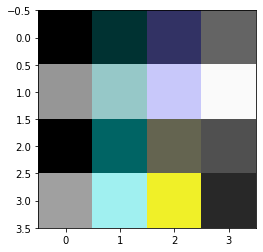

In [61]:
image = arr.reshape(4, 4, 3)
plt.imshow(arr.reshape(4, 4, 3))
print('lin_space', np.linspace(0, 4, 3).astype(np.int8))

In [62]:
images = split_image(image, 4, 2, 2)

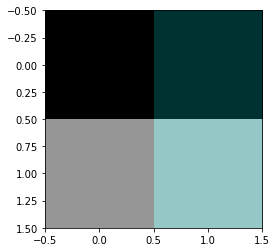

In [63]:
f = images[0]
plt.imshow(f)
plt.imshow(images[0]);


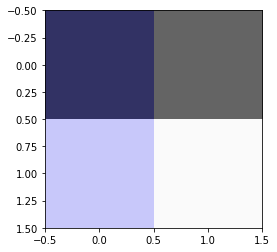

In [64]:
plt.imshow(images[1]);

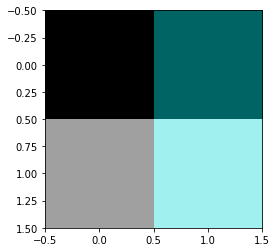

In [65]:
plt.imshow(images[2]);


<class 'numpy.ndarray'>


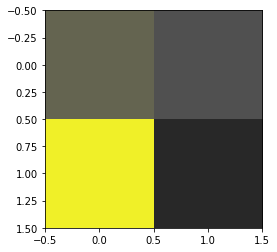

In [77]:
plt.imshow(images[3])
print(type(images[3]))

In [67]:
images[0].shape

(2, 2, 3)

(4, 4, 3) <class 'numpy.ndarray'>


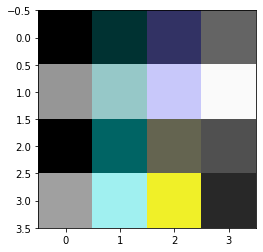

In [79]:
recombined = stich_images(images)
print(recombined.shape, type(recombined))
plt.imshow(recombined/255)

In [54]:
arr.reshape(4, 4, 3)

array([[[  0,   0,   0],
        [  0,  50,  50],
        [ 50,  50, 100],
        [100, 100, 100]],

       [[150, 150, 150],
        [150, 200, 200],
        [200, 200, 250],
        [250, 250, 250]],

       [[  0,   0,   0],
        [  0, 100, 100],
        [100, 100,  80],
        [ 80,  80,  80]],

       [[160, 160, 160],
        [160, 240, 240],
        [240, 240,  40],
        [ 40,  40,  40]]])

In [ ]:
split_dimension = 2
dimension = 2
split_imgs = []
for i in range(split_dimension):
    for j in range(split_dimension):
        split_imgs.append()
        

In [46]:
img_square = load_img('rgb_square.png')
arrs = img_to_array(rgb)

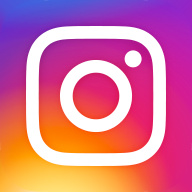

In [47]:
img_square

/home/greg/anaconda3/envs/metis/lib/python3.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:78: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "


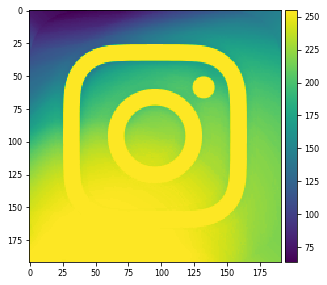

In [52]:
imshow(arrs[..., 0])

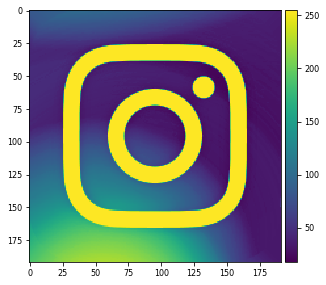

In [53]:
imshow(arrs[..., 1])

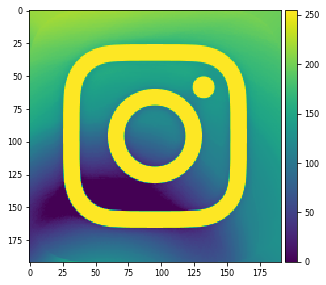

In [54]:
imshow(arrs[..., 2])

In [194]:
image_paths = glob.glob('data/spacenet/AOI_2_Vegas_Train/RGB-PanSharpen_resize640_split128/RGB-PanSharpen_AOI_2_Vegas_img1007_part*')
mask_paths = glob.glob('data/spacenet/AOI_2_Vegas_Train/RGB-PanSharpen_masks_resize640_split128/AOI_2_Vegas_img1007_mask_part*')
image_paths = sorted(image_paths)
mask_paths = sorted(mask_paths)
img = tifffile.imread(image_paths[8])
mask = tifffile.imread(mask_paths[8])
print(img.max(), mask.max())

1503.4997558593536 255.0


(<Figure size 988.8x604.8 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7efc58d78590>)

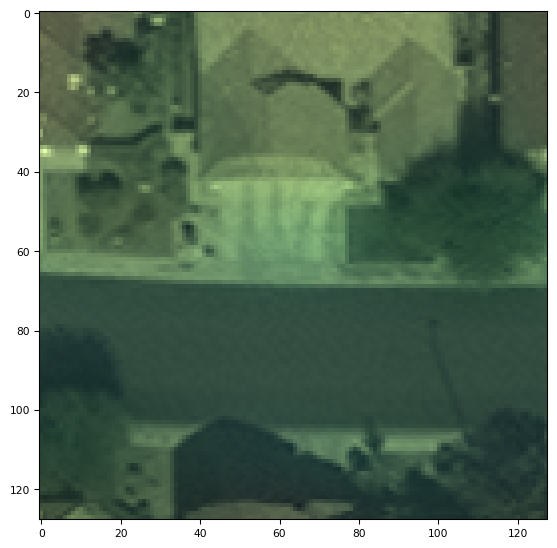

In [195]:
tifffile.imshow(img)

(<Figure size 988.8x604.8 with 3 Axes>,
 <matplotlib.image.AxesImage at 0x7efc58ce43d0>)

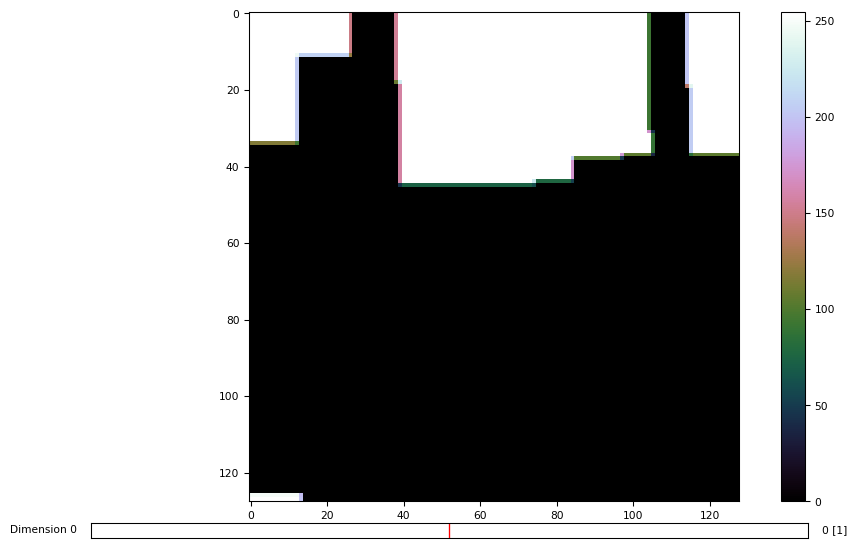

In [196]:
tifffile.imshow(mask)

In [189]:
all_images = []
for image_path in image_paths:
    all_images.append(tifffile.imread(image_path))

all_masks = []
for mask_path in mask_paths:
    all_masks.append(tifffile.imread(mask_path))

    

(<Figure size 988.8x604.8 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7efc58f527d0>)

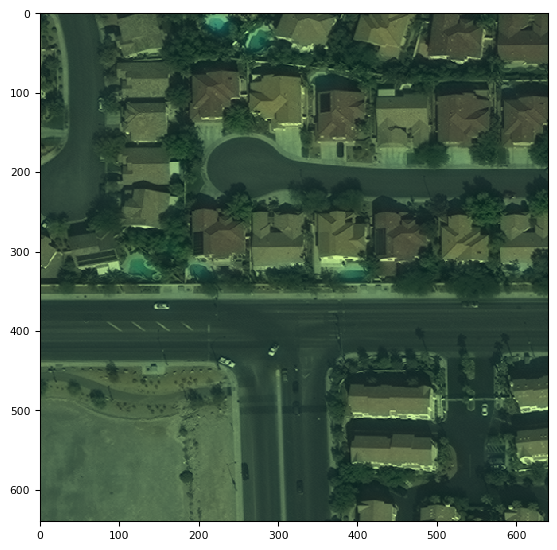

In [190]:
stiched = stich_images(all_images)
tifffile.imshow()

(<Figure size 988.8x604.8 with 3 Axes>,
 <matplotlib.image.AxesImage at 0x7efc58edf950>)

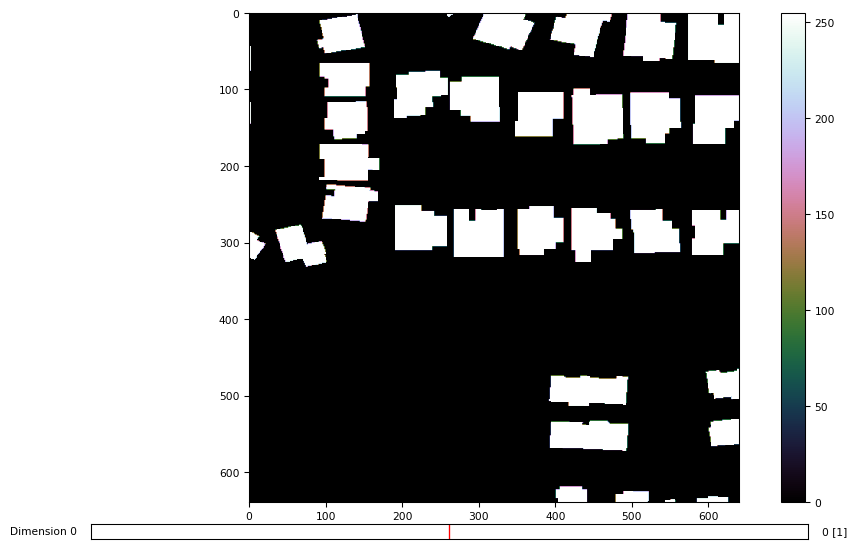

In [191]:
stiched_masks = stich_images(all_masks)
tifffile.imshow(stiched_masks)

In [192]:
X_train = np.random.randint(1, 10, 25 * 4 * 4).reshape(25, 4, 4)
y_train = np.random.randint(1, 10, 25 * 4 * 4).reshape(25, 4, 4)

/home/greg/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: No contour levels were found within the data range.
  if sys.path[0] == '':


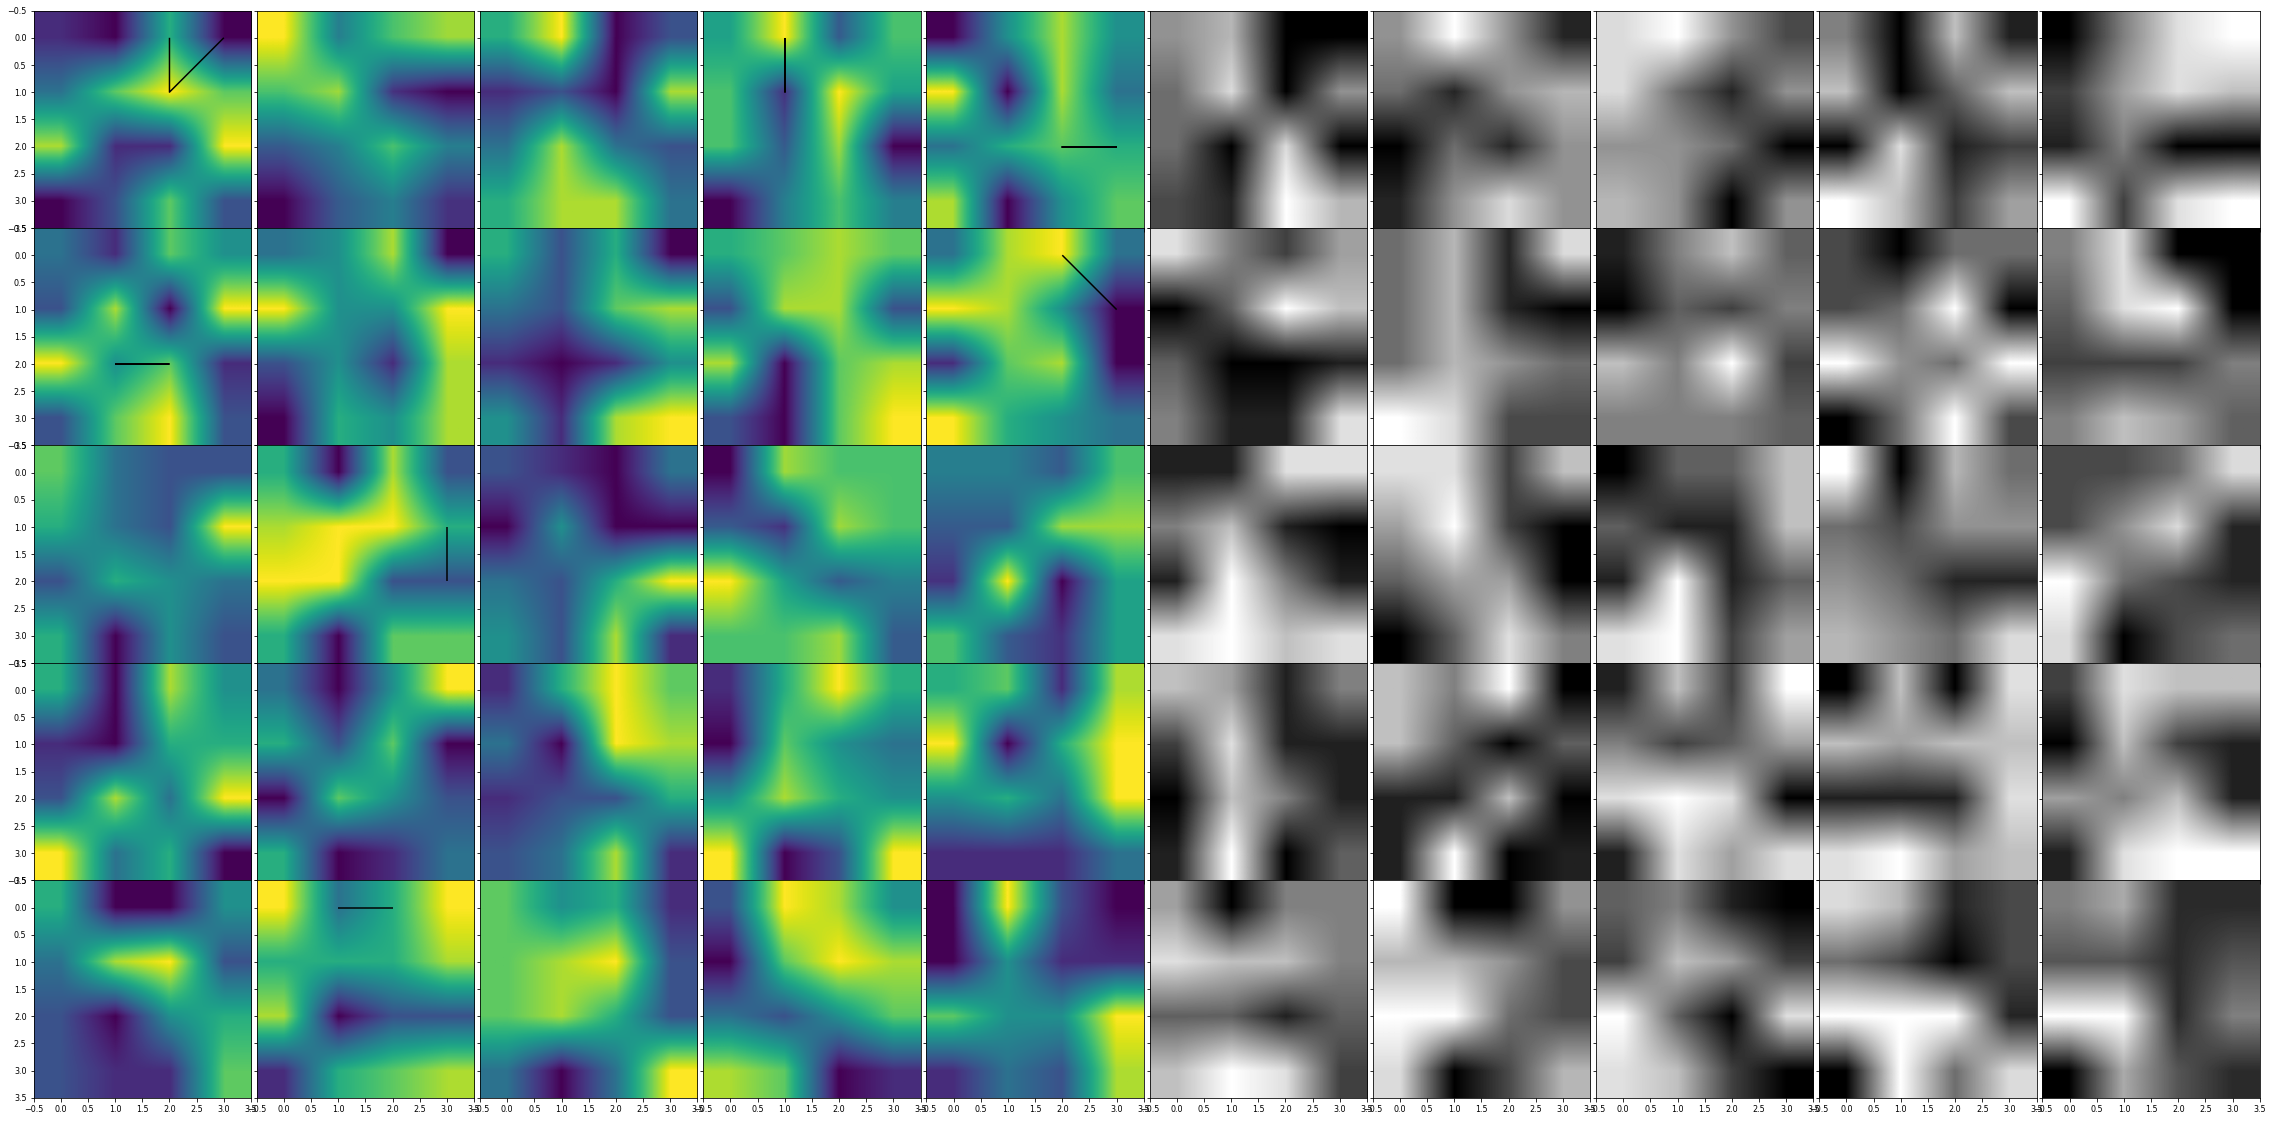

In [146]:
fig, axs = plt.subplots(
    5, 10,
    sharex=True, sharey=True,
    gridspec_kw={'hspace': 0, 'wspace': 0},
    figsize=(20, 10)
)

ix = 0
for i in range(5):
    for j in range(5):
        axs[i, j].imshow(X_train[ix], interpolation='bilinear')
        axs[i, j].contour(y_train[ix].squeeze(), colors='k', levels=[0.5])
        ix += 1

ix = 0
for i in range(0, 5):
    for j in range(5, 10):
        axs[i, j].imshow(y_train[ix].squeeze(),
                        interpolation='bilinear', cmap='gray')
        ix += 1
        
for ax_row in axs:
    for ax in ax_row:
        ax.label_outer()

In [ ]:
### looking at xview snippet 